In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
# Plot styling
plt.style.use("ggplot")
custom_palette = [
    "#E24A33",
    "#348ABD",
    "#988ED5",
    "#777777",
    "#FBC15E",
    "#8EBA42",
    "#FFB5B8",
    "#17BECF",
]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=custom_palette)

# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


# TEOTIL3 results for Raet national park

In [4]:
par_list = ["totn", "totp"]

In [5]:
# Map regines to areas of interest around Raet
raet_df = pd.read_excel("raet_regines_to_areas.xlsx")
raet_df.head()

,regine,Område,Beskrivelse
0,019.A11,Nidelva,Nidelva and tributaries upstream of Skarpenest...
1,019.214,Fevik coastal,NaN
2,019.213,Fevik coastal,NaN
3,019.212Z,Nedenes coastal,NaN
4,019.2120,Nedenes coastal,NaN


In [6]:
# Get regines
reg_gdf = teo.io.get_regine_geodataframe(eng, 2022)

# Read single input file and build network
data_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
csv_path = os.path.join(
    data_fold,
    "teotil3_input_data_nve2023_2022.csv",
)
in_df = pd.read_csv(csv_path)
g = teo.model.build_graph(in_df, id_col="regine", next_down_col="regine_down")

# Read model results
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"
mod_csv = os.path.join(eval_fold, "teo3_results_nve2023_2013-2022.csv")
mod_df = pd.read_csv(mod_csv)

# Tidy
mod_df["År"] = mod_df["year"]
cols = [i for i in mod_df.columns if i.split("_")[0] == "accum"]
mod_df = mod_df[["regine", "År"] + cols]
for col in mod_df.columns:
    if col.endswith("_kg"):
        new_col = col.replace("_kg", "_tonnes")
        mod_df[new_col] = mod_df[col] / 1000
        del mod_df[col]

mod_df.head()

/home/jovyan/projects/teotil3/teotil3/io.py:288: FutureWarning: The `drop` keyword argument is deprecated and in future the only supported behaviour will match drop=False. To silence this warning and adopt the future behaviour, stop providing `drop` as a keyword to `set_geometry`. To replicate the `drop=True` behaviour you should update your code to
`geo_col_name = gdf.active_geometry_name; gdf.set_geometry(new_geo_col).drop(columns=geo_col_name).rename_geometry(geo_col_name)`.
  gdf.set_geometry("geometry", drop=False, inplace=True)


,regine,År,accum_q_m3/s,accum_upstr_area_km2,accum_agriculture-background_din_tonnes,accum_agriculture-background_ss_tonnes,accum_agriculture-background_tdp_tonnes,accum_agriculture-background_toc_tonnes,accum_agriculture-background_ton_tonnes,accum_agriculture-background_totn_tonnes,...,accum_urban_totp_tonnes,accum_urban_tpp_tonnes,accum_wood_din_tonnes,accum_wood_ss_tonnes,accum_wood_tdp_tonnes,accum_wood_toc_tonnes,accum_wood_ton_tonnes,accum_wood_totn_tonnes,accum_wood_totp_tonnes,accum_wood_tpp_tonnes
0,001.10,2013,0.019586,1.160850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.036100,0.849200,0.000600,9.938900,0.186200,0.222300,0.005400,0.004800
1,001.1A2B,2013,0.749662,41.298255,0.123574,0.000752,0.003421,6.341957,0.068506,0.192080,...,0.005028,0.000079,0.249787,0.002473,0.014250,130.041203,2.968042,3.217828,0.016873,0.002623
2,001.1A4D,2013,0.129308,6.970095,0.015918,0.000289,0.000117,0.464713,0.006730,0.022647,...,0.000000,0.000000,0.096253,0.007898,0.003457,41.327191,0.889638,0.985890,0.006699,0.003242
3,001.1M,2013,0.272519,15.252385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.137471,0.002187,0.005979,61.598816,1.477061,1.614532,0.008126,0.002148
4,001.21,2013,0.001987,0.117073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.005000,0.117000,0.000100,1.386100,0.025900,0.030900,0.000800,0.000700


## 1. Map of areas of interest

In [7]:
gdf_list = []
for idx, row in raet_df.iterrows():
    reg_down = row["regine"]
    area = row["Område"]
    g2 = nx.dfs_tree(g.reverse(), reg_down).reverse()
    node_list = list(g2.nodes)
    cat_gdf = reg_gdf.query("regine in @node_list").copy()
    cat_gdf["dissolve_field"] = 1
    cat_gdf = cat_gdf.dissolve(by="dissolve_field").reset_index(drop=True)
    cat_gdf["Område"] = area
    cat_gdf = cat_gdf[["Område", "geometry"]]
    gdf_list.append(cat_gdf)
raet_gdf = pd.concat(gdf_list, axis="rows")
raet_gdf = raet_gdf.dissolve(by="Område").reset_index()
raet_gdf.head()

,Område,geometry
0,Arendal coastal,"POLYGON ((135146.912 6495285.238, 135087.11 64..."
1,Eyde coastal,"POLYGON ((142320.81 6503704.31, 142322.2 65036..."
2,Fevik coastal,"POLYGON ((129478.34 6488540.42, 129497.521 648..."
3,Hisøy,"POLYGON ((137402.55 6494774.4, 137406.11 64945..."
4,Lyngør coastal,"POLYGON ((161858.589 6516453.773, 162480.722 6..."


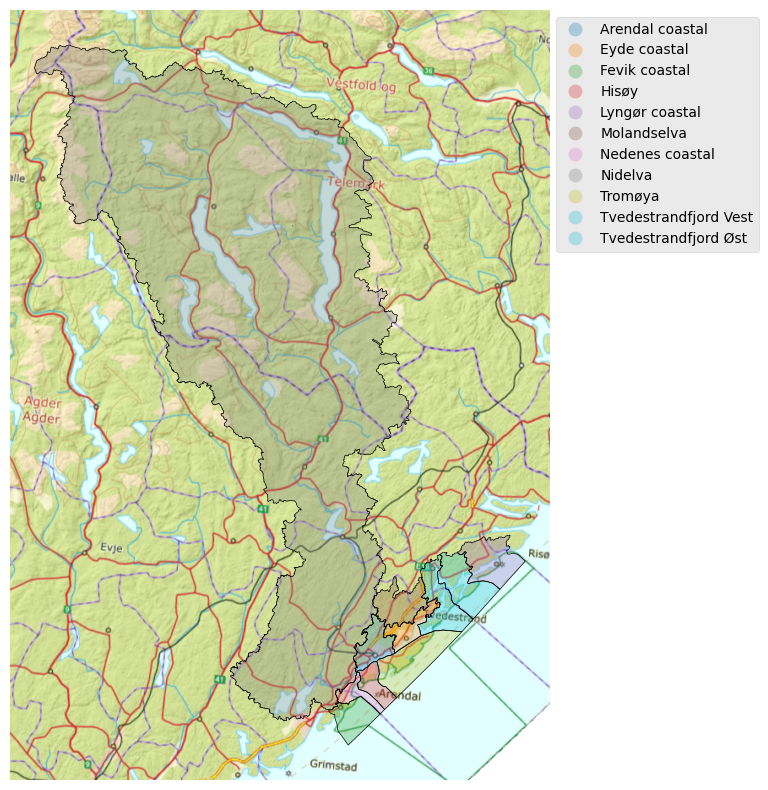

In [8]:
ax = raet_gdf.plot(column="Område", figsize=(10, 10), alpha=0.3, legend=True)
raet_gdf.plot(ax=ax, edgecolor="k", facecolor="none")
cx.add_basemap(
    ax,
    crs=raet_gdf.crs,
    attribution=False,
    source="http://opencache.statkart.no/gatekeeper/gk/gk.open_gmaps?layers=topo4&zoom={z}&x={x}&y={y}",
)
ax.set_axis_off()
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4, 1))
plt.savefig("raet_subareas.png", dpi=200, bbox_inches="tight")

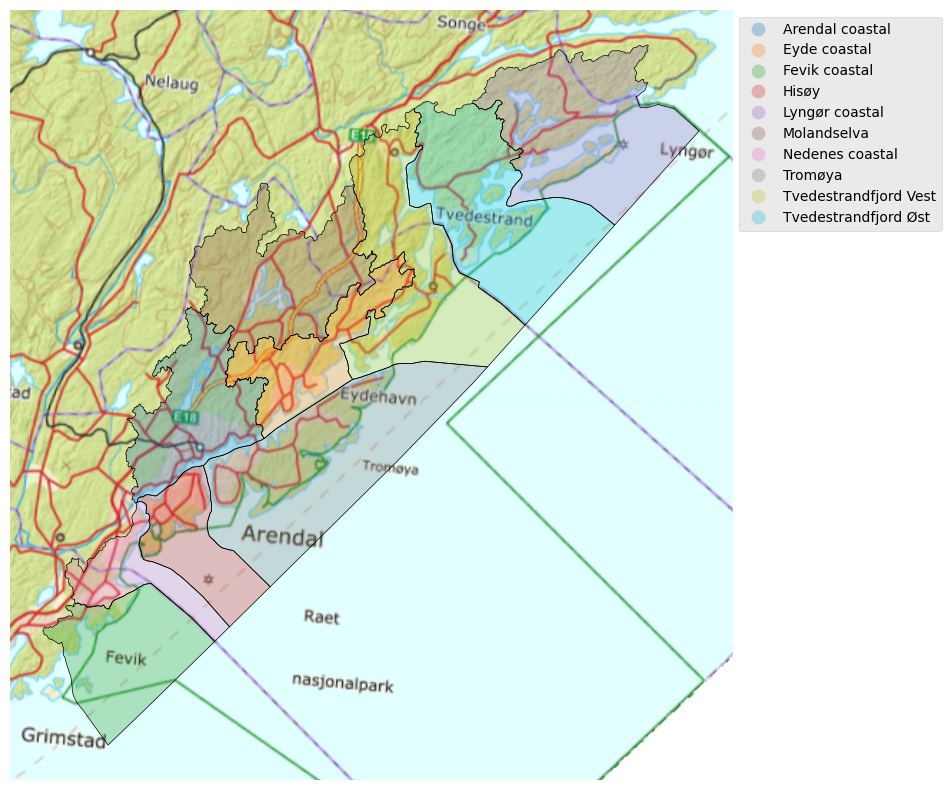

In [14]:
raet_gdf2 = raet_gdf.query("`Område` != 'Nidelva'")
ax = raet_gdf2.plot(column="Område", figsize=(10, 10), alpha=0.3, legend=True)
raet_gdf2.plot(ax=ax, edgecolor="k", facecolor="none")
cx.add_basemap(
    ax,
    crs=raet_gdf.crs,
    attribution=False,
    source="http://opencache.statkart.no/gatekeeper/gk/gk.open_gmaps?layers=topo4&zoom={z}&x={x}&y={y}",
)
ax.set_axis_off()
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.3, 1))
plt.savefig("raet_subareas_excl_nidelva.png", dpi=200, bbox_inches="tight")

In [10]:
reg_list = raet_df["regine"].tolist()
mod_df = mod_df.query("regine in @reg_list")
res_df = (
    pd.merge(mod_df, raet_df, how="left", on="regine")
    .groupby(["Område", "År"])
    .sum(numeric_only=True)
    .reset_index()
)

res_dict = {}
for par in par_list:
    par_df = res_df.copy()
    agg_dict = {
        "Akvakultur": [f"accum_aquaculture_{par}_tonnes"],
        "Jordbruk": [f"accum_agriculture_{par}_tonnes"],
        "Avløp": [
            f"accum_large-wastewater_{par}_tonnes",
            f"accum_spredt_{par}_tonnes",
        ],
        "Industri": [f"accum_industry_{par}_tonnes"],
        "Bebygd": [f"accum_urban_{par}_tonnes"],
        "Bakgrunn": [
            f"accum_agriculture-background_{par}_tonnes",
            f"accum_upland_{par}_tonnes",
            f"accum_wood_{par}_tonnes",
            f"accum_lake_{par}_tonnes",
        ],
    }
    for group, cols in agg_dict.items():
        par_df[group] = par_df[cols].sum(axis=1)
    par_df = par_df[["Område", "År"] + list(agg_dict.keys())]

    # Calculate totals
    par_df["Menneskeskapt"] = (
        par_df["Akvakultur"]
        + par_df["Jordbruk"]
        + par_df["Avløp"]
        + par_df["Industri"]
        + par_df["Bebygd"]
    )
    par_df["Totalt"] = par_df["Menneskeskapt"] + par_df["Bakgrunn"]
    res_dict[par] = par_df

In [11]:
# Totals for whole area
for par in par_list:
    orig_par_df = res_dict[par].copy()
    tot_df = orig_par_df.groupby("År").sum(numeric_only=True).reset_index()
    tot_df["Område"] = "Raet nasjonalpark (alle områder)"
    par_df = pd.concat([orig_par_df, tot_df], axis="rows")
    res_dict[par] = par_df

In [12]:
# Create summary PDF with one page per vassdragsområde
sources = [
    "Akvakultur",
    "Jordbruk",
    "Avløp",
    "Industri",
    "Bebygd",
    "Bakgrunn",
]

with PdfPages("teotil3_raet_summary_2013-2022.pdf") as pdf:
    for area in res_dict["totn"]["Område"].unique():
        fig, axs = plt.subplots(
            3, 2, figsize=(10, 8), gridspec_kw={"height_ratios": [1, 0.2, 1]}
        )
        fig.suptitle(area, fontsize=16)
        fig.delaxes(axs[1, 0])
        fig.delaxes(axs[1, 1])
        for i, par in enumerate(par_list):
            df = res_dict[par][res_dict[par]["Område"] == area].copy()
            df = df.drop(columns="Område").set_index("År")

            # Stacked bar chart
            df[sources].plot(kind="bar", stacked=True, ax=axs[0, i], legend=False)
            axs[0, i].set_title(par.upper())
            axs[0, i].set_xlabel("")
            axs[0, i].set_ylabel(f"{par.upper()} (tonn)")

            # Horizontal bar chart
            df_period = df[sources]
            total_sources = df_period[sources].sum()
            percentages = (total_sources / total_sources.sum()) * 100
            percentages = percentages.sort_values()
            percentages.plot(kind="barh", ax=axs[2, i])
            axs[2, i].set_title(f"{par.upper()} i prosent\n(gjennomsnitt 2013-2022)")
            axs[2, i].set_xlabel("Prosent")
            axs[2, i].set_ylabel("")
            for index, value in enumerate(percentages):
                axs[2, i].text(value, index, f"{value:.1f}%", va="center")

        # Add legends below the specified subplots
        handles, labels = axs[0, 0].get_legend_handles_labels()
        fig.legend(
            handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.53), ncol=3
        )
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)